# Imports

In [42]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F
from IPython.display import HTML

# Data

In [43]:
mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256
x_dim = 64

dataset = FashionMNIST('../data/FashionMNIST', download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(x_dim),
                                 transforms.Normalize((mean,), (std,))
                             ]))


data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Model

Print Layer (debugging)

In [44]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Generator

In [50]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.latent_dim, out_channels=64*8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64*8, out_channels=64*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x

Discriminator

In [51]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64*2, out_channels=64*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64*4, out_channels=64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64*8, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.conv_layers(x).view(-1, 1).squeeze(1)
        return x

# Training

In [52]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
disc_net = Discriminator().to(device)
disc_net.apply(weights_init)
gen_net = Generator().to(device)
gen_net.apply(weights_init)
criterion = nn.BCELoss()
num_epochs = 5
lr = 0.0002
beta1 = 0.5

fixed_noise = torch.randn(256, 128, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.AdamW(disc_net.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.AdamW(gen_net.parameters(), lr=lr, betas=(beta1, 0.999))

In [56]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(data_loader, 0):
        # Train with all-real batch
        disc_net.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = disc_net(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        noise = torch.randn(b_size, 128, 1, 1, device=device)
        fake = gen_net(noise)
        label.fill_(fake_label)
        output = disc_net(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        gen_net.zero_grad()
        label.fill_(real_label)
        output = disc_net(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = gen_net(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/235]	Loss_D: 0.0265	Loss_G: 5.0899	D(x): 0.9918	D(G(z)): 0.0177 / 0.0088
[0/5][50/235]	Loss_D: 1.1944	Loss_G: 2.0826	D(x): 0.5396	D(G(z)): 0.1256 / 0.2311
[0/5][100/235]	Loss_D: 0.3525	Loss_G: 4.0505	D(x): 0.8435	D(G(z)): 0.0852 / 0.0416
[0/5][150/235]	Loss_D: 0.0244	Loss_G: 5.6864	D(x): 0.9835	D(G(z)): 0.0074 / 0.0051
[0/5][200/235]	Loss_D: 0.0141	Loss_G: 6.1435	D(x): 0.9903	D(G(z)): 0.0036 / 0.0030
[1/5][0/235]	Loss_D: 0.0170	Loss_G: 6.0351	D(x): 0.9941	D(G(z)): 0.0110 / 0.0029
[1/5][50/235]	Loss_D: 0.0065	Loss_G: 6.7271	D(x): 0.9965	D(G(z)): 0.0030 / 0.0017
[1/5][100/235]	Loss_D: 0.0042	Loss_G: 6.8546	D(x): 0.9975	D(G(z)): 0.0016 / 0.0013
[1/5][150/235]	Loss_D: 0.0021	Loss_G: 7.4618	D(x): 0.9989	D(G(z)): 0.0010 / 0.0006
[1/5][200/235]	Loss_D: 0.0015	Loss_G: 7.5479	D(x): 0.9992	D(G(z)): 0.0008 / 0.0005
[2/5][0/235]	Loss_D: 0.0008	Loss_G: 7.8591	D(x): 0.9997	D(G(z)): 0.0005 / 0.0004
[2/5][50/235]	Loss_D: 0.0006	Loss_G: 7.9746	D(x): 0.9999	D(G(z)): 0.0005 / 0.0003
[2/5][100/235

# Evaluation


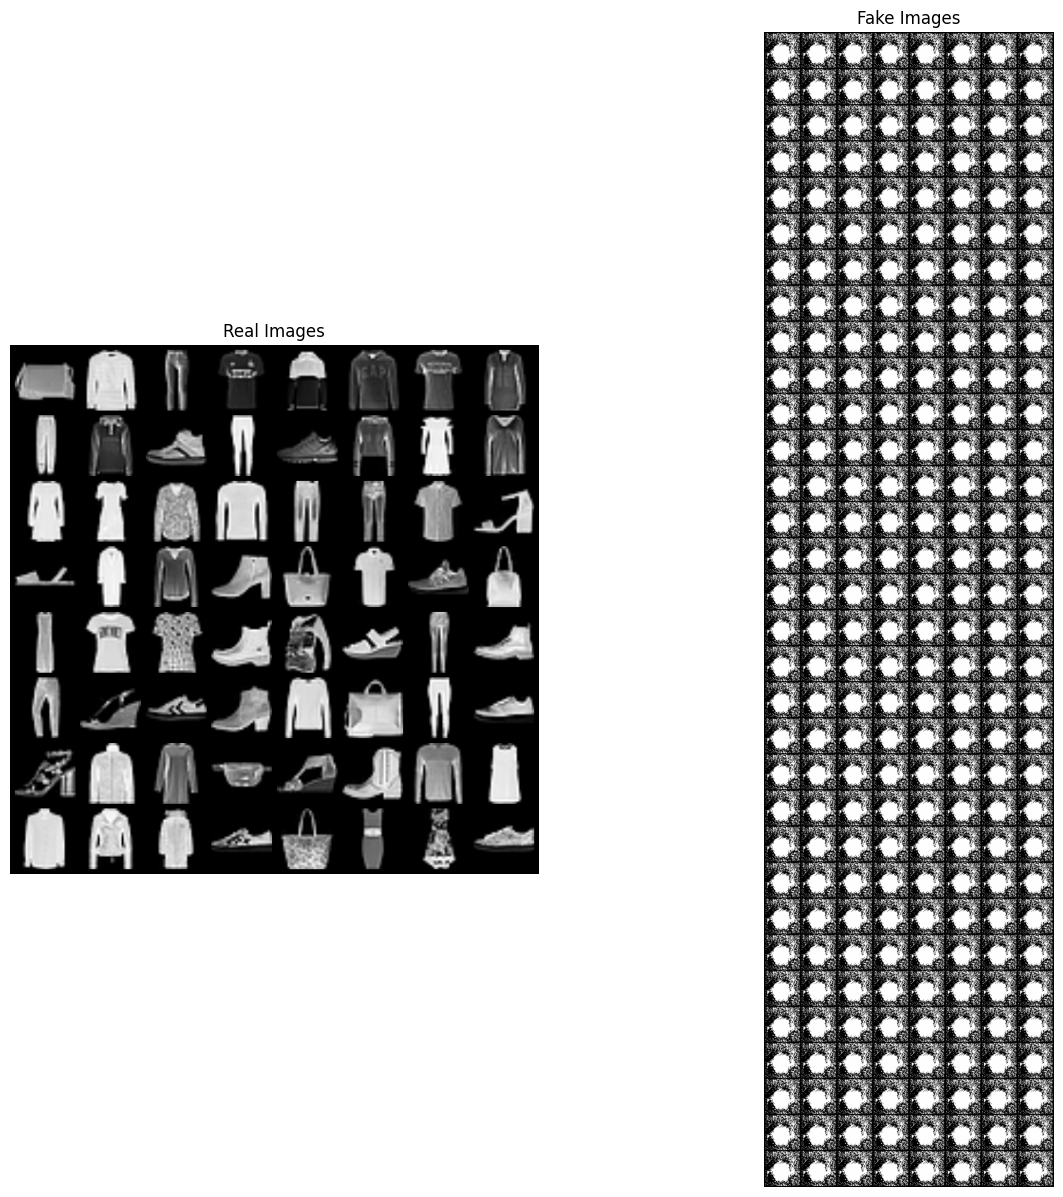

In [57]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(data_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()